# Expore data

## Import & definitions

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 48 # days used to predict next values in future
FUTURE_TARGET = 13 # nb predict days later
STEP = 1

path_save_df_feat = "data/df_feat.csv"

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  "data/mdl_autoencoder"
path_mdl_encoder  =  "data/mdl_encoder"
path_mdl_predict_lstm  =  "data/mdl_predict_lstm"
path_mdl_predict_autoenc_lstm  =  "data/mdl_predict_autoenc_lstm"

## Load raw features

In [2]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2322.297304,2314.547318,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.362500,1686.740000,1701.275,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.635000,1686.740000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.912500,1686.740000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.155000,1676.255000,1696.365,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [3]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
rsi_h_BTC                  13
min_low_h_ETH              13
min_low_h_BTC              13
chop_h_BTC                 13
rsi_h_ETH                  13
max_high_h_ETH             13
max_high_h_BTC             13
chop_h_ETH                 13
ichi_cloud_a_BTC           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_ETH           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
rsi_d_ETH                 335
min_low_d_BTC             335
max_high_d_BTC            335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
chop_d_ETH                335
chop_d_BTC                335
ichi_cloud_a_day_ETH      623
ichi_cloud_a_day_BTC      623
ichi_kijun_day_ETH        623
ichi_kijun_day_BTC        623
dxy                      1109
fvx                      1117
spx                     

<AxesSubplot: >

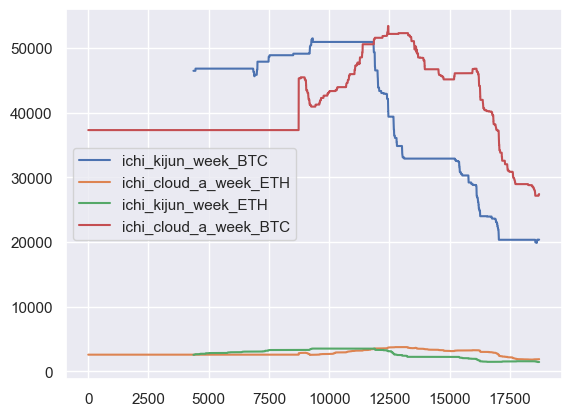

In [4]:
df_feat_raw[["ichi_kijun_week_BTC"   ,    
"ichi_cloud_a_week_ETH"   ,  
"ichi_kijun_week_ETH"    ,   
"ichi_cloud_a_week_BTC"]].plot()

### drop nan

In [5]:
print(df_feat_raw.shape)
df_feat = df_feat_raw.dropna(subset=["ichi_kijun_week_ETH"]).copy()
df_feat.reset_index(inplace=True)
df_feat.shape

(18720, 135)


(14353, 136)

In [6]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       14281
delta_event_real    14281
delta_event_pred    14281
Previous_num        14281
Actual_num          14281
Event               14281
Date                14281
Previous            14281
Consensus           14281
Actual              14281
Country             14281
Time (ET)           14281
keep                14281
date                14281
dtype: int64

on 14353 samples


## Features Selection

### Propotional to the Price

In [7]:
list_col = df_feat.columns.to_list()
list_col

['index',
 'Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ra

In [8]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [9]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,2188.2400,2174.775,2177.520,2107.755,...,1997.853156,1997.853156,1997.853156,1997.853156,1997.853156,0.155010,0.051536,1.166930e+08,527404.0,17.768278
1,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,2188.2400,2174.775,2177.520,2107.755,...,1997.866014,1997.866014,1997.866014,1997.866014,1997.866014,0.196095,0.064310,1.167075e+08,501748.0,17.533440
2,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,2188.2400,2174.775,2174.525,2107.755,...,1997.879702,1997.879702,1997.879702,1997.879702,1997.879702,0.127771,0.042859,1.167075e+08,501748.0,17.533440
3,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,2189.4400,2174.775,2170.405,2107.755,...,1997.887496,1997.887496,1997.887496,1997.887496,1997.887496,0.137944,0.046109,1.167075e+08,501748.0,17.533440
4,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,2192.3925,2174.775,2149.315,2086.980,...,1997.900078,1997.900078,1997.900078,1997.900078,1997.900078,0.061857,0.021213,1.167075e+08,501748.0,17.533440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14348,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.3625,1686.740,1701.275,1701.275,...,1481.323268,2188.054792,2111.076664,1678.918304,2111.076664,-0.434231,-0.253013,1.204898e+08,378594.0,18.271360
14349,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.6350,1686.740,1696.365,1696.365,...,1481.340579,2188.000699,2111.056629,1678.890186,2111.056629,-0.432006,-0.251390,1.204898e+08,378594.0,18.271360
14350,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.9125,1686.740,1696.365,1696.365,...,1481.328420,2187.972888,2111.047664,1678.854499,2111.047664,-0.433023,-0.252126,1.204898e+08,378594.0,18.271360
14351,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.1550,1676.255,1696.365,1696.365,...,1481.219019,2187.949432,2111.042320,1678.829900,2111.042320,-0.433452,-0.252435,1.204898e+08,378594.0,18.271360


In [10]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [11]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [12]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [13]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [14]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [15]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'index',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_si

In [16]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [17]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global
print("num features : ", len(list_col_select))

num features :  104


In [18]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [19]:
df_feat["event_real"].describe()

count    14353.000000
mean        -0.000697
std          0.050079
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: event_real, dtype: float64

In [20]:
df_feat["event_real"].value_counts()

 0.0    14317
-1.0       23
 1.0       13
Name: event_real, dtype: int64

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [21]:
df_feat.shape[0]

14353

In [22]:
TRAIN_SPLIT = round(0.8 * df_feat.shape[0])
TRAIN_SPLIT

11482

In [23]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,4367,1625180400000,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,4368,1625184000000,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,4369,1625187600000,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,2188.2400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,4370,1625191200000,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,2189.4400,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,4371,1625194800000,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,2192.3925,2174.775,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14348,18715,1676833200000,1685.63,1690.13,1683.49,1684.80,11298.92820,2023-02-19 19:00:00,1692.3625,1686.740,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14349,18716,1676836800000,1684.80,1687.81,1666.14,1686.97,28031.41140,2023-02-19 20:00:00,1697.6350,1686.740,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14350,18717,1676840400000,1686.98,1687.14,1682.07,1685.97,12684.47480,2023-02-19 21:00:00,1696.9125,1686.740,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
14351,18718,1676844000000,1685.97,1688.85,1681.75,1685.55,7566.94370,2023-02-19 22:00:00,1696.1550,1676.255,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [24]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [25]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [26]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [27]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11422, 48, 104) (11422, 13)
(2809, 48, 104) (2809, 13)


In [28]:
seq_y

array([1.00147619, 1.00217625, 1.00080658, 0.99955866, 0.99790746,
       0.9955562 , 0.99863034, 0.9992619 , 0.99669759, 0.99583774,
       0.99621059, 0.99648453, 0.99804442])

In [29]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [1.00031266, 1.00219628, 1.00367571, ..., 0.99888661, 0.99802488,
        0.99839855],
       [1.00188302, 1.003362  , 1.00406337, ..., 0.99771293, 0.99808648,
        0.99836093],
       [1.00147619, 1.00217625, 1.00080658, ..., 0.99621059, 0.99648453,
        0.99804442]])

In [30]:
seq_y

array([1.00147619, 1.00217625, 1.00080658, 0.99955866, 0.99790746,
       0.9955562 , 0.99863034, 0.9992619 , 0.99669759, 0.99583774,
       0.99621059, 0.99648453, 0.99804442])

In [31]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [1.00031266, 1.00219628, 1.00367571, ..., 0.99888661, 0.99802488,
        0.99839855],
       [1.00188302, 1.003362  , 1.00406337, ..., 0.99771293, 0.99808648,
        0.99836093],
       [1.00147619, 1.00217625, 1.00080658, ..., 0.99621059, 0.99648453,
        0.99804442]])

In [32]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [33]:
X_train.shape

(11422, 48, 104)

In [34]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(11422, 48, 104) (11422, 13)
(2809, 48, 104) (2809, 13)


## Standardization

In [35]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [36]:
scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.reshape(-1,y_test.shape[-1])).reshape(y_test.shape)

In [37]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [1.00031266, 1.00219628, 1.00367571, ..., 0.99888661, 0.99802488,
        0.99839855],
       [1.00188302, 1.003362  , 1.00406337, ..., 0.99771293, 0.99808648,
        0.99836093],
       [1.00147619, 1.00217625, 1.00080658, ..., 0.99621059, 0.99648453,
        0.99804442]])

In [38]:
np.mean(y_train_sca)

-2.522827237432126e-14

In [39]:
np.std(y_train_sca)

0.9999999999999997

### Check unscaling

In [40]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,month_cos,month_sin,day_off,event_pred,event_real
0,2106.41,2128.88,2135.07,2104.88,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,-0.258819,-0.900969,0.433884,0.979530,0.201299,-0.866025,-0.5,0.0,0.0,0.0
1,2135.18,2106.41,2136.00,2096.00,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,0.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
2,2087.34,2135.50,2139.00,2084.04,2188.2400,2174.775,2174.525,2107.755,2793.485,3050.73,...,0.258819,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
3,2094.46,2087.45,2103.64,2082.00,2189.4400,2174.775,2170.405,2107.755,2793.485,3050.73,...,0.500000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
4,2041.20,2094.45,2095.74,2033.96,2192.3925,2174.775,2149.315,2086.980,2793.485,3050.73,...,0.707107,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
5,2054.86,2041.19,2058.85,2035.61,2203.5250,2174.775,2134.385,2086.980,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
6,2032.84,2054.86,2058.77,2023.41,2211.6375,2180.675,2129.110,2081.705,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
7,2034.03,2032.92,2041.86,2018.50,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,1.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
8,2061.49,2034.35,2070.00,2028.98,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
9,2060.50,2061.49,2080.46,2051.48,2203.1750,2186.930,2094.295,2078.750,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0


In [41]:
df_feat["Close_ETH"].iloc[0:10]

0    2106.41
1    2135.18
2    2087.34
3    2094.46
4    2041.20
5    2054.86
6    2032.84
7    2034.03
8    2061.49
9    2060.50
Name: Close_ETH, dtype: float64

In [42]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [43]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]
X_train_raw:      [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]


In [44]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1309.57 1304.14 1306.92 1308.27 1311.17 1313.6  1312.44 1328.69 1329.4
 1330.85]
X_test_raw     :  [1309.57 1304.14 1306.92 1308.27 1311.17 1313.6  1312.44 1328.69 1329.4
 1330.85]


## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [45]:
X_train_sca.shape

(11422, 48, 104)

In [46]:
X_train_sca[:,-1,:].shape

(11422, 104)

In [47]:
y_train_sca[:,0][:, np.newaxis]

array([[ 1.05753603],
       [-0.99416158],
       [-0.50740963],
       ...,
       [ 0.03454238],
       [ 0.20621186],
       [ 0.16173785]])

In [48]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(11422, 105)

In [49]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

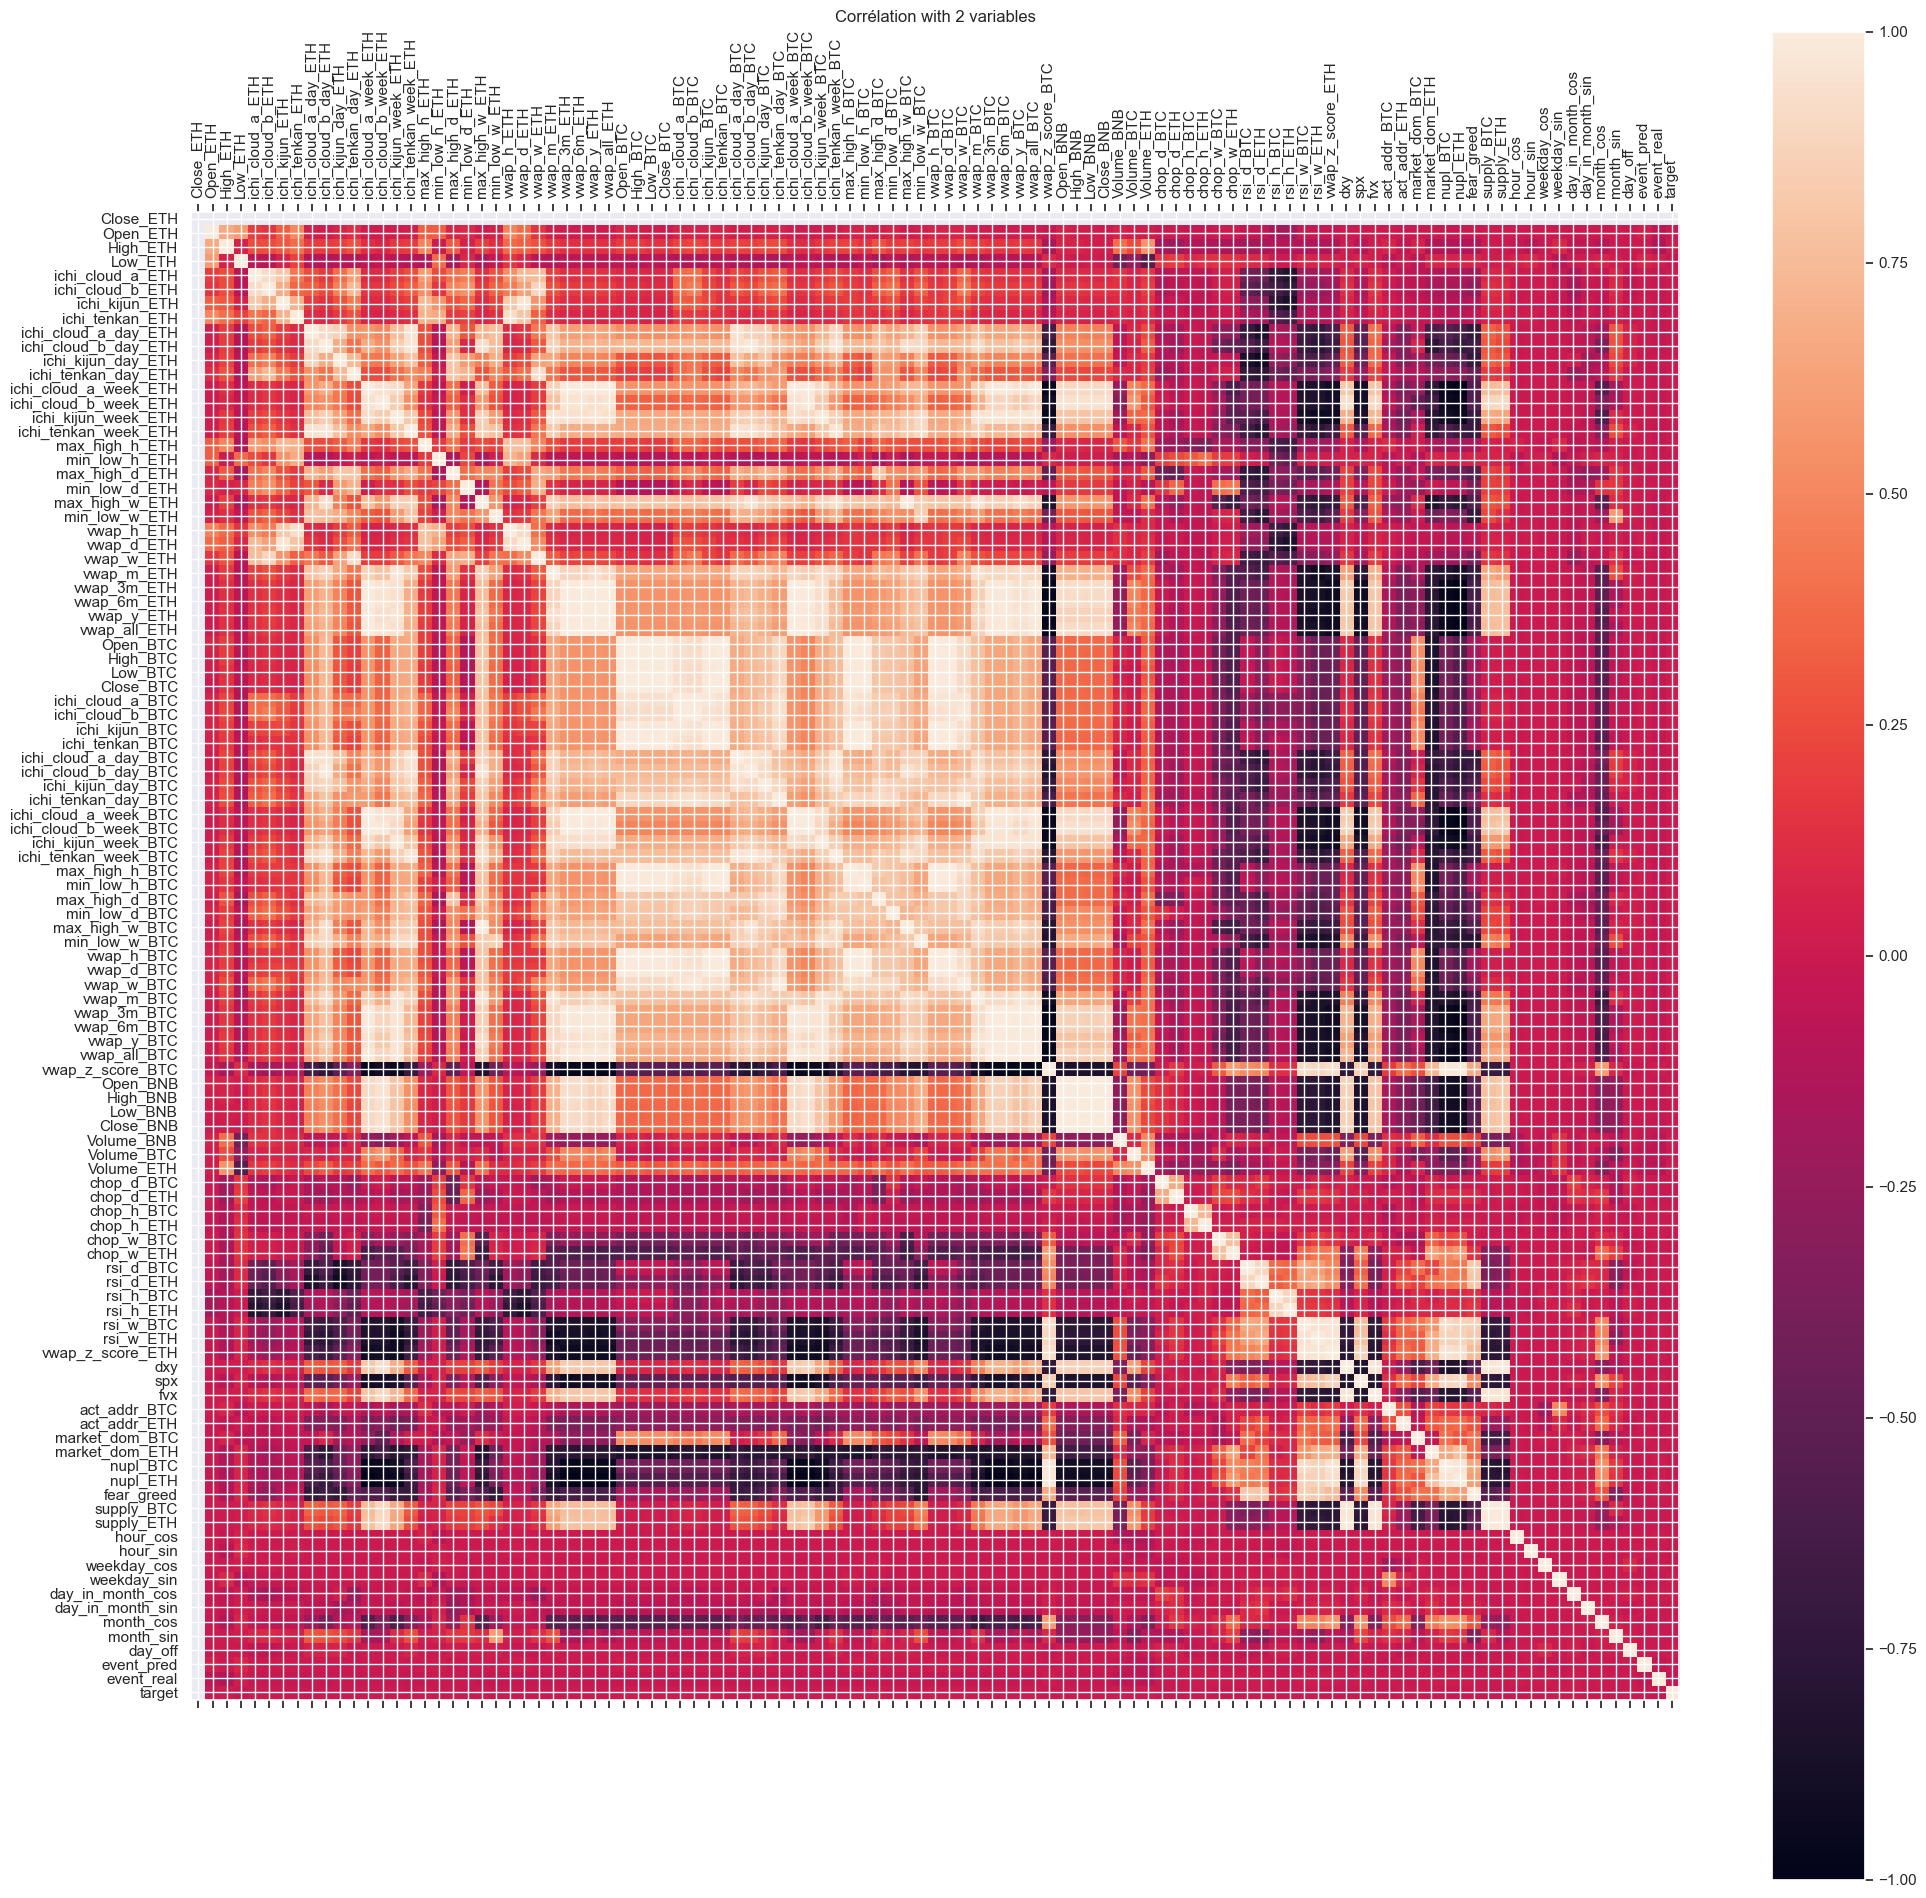

In [50]:

nb_plot = 104
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
    columns=list_col_select[:nb_plot] + ['target'])

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(24, 24))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()


In [51]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [1.00031266, 1.00219628, 1.00367571, ..., 0.99888661, 0.99802488,
        0.99839855],
       [1.00188302, 1.003362  , 1.00406337, ..., 0.99771293, 0.99808648,
        0.99836093],
       [1.00147619, 1.00217625, 1.00080658, ..., 0.99621059, 0.99648453,
        0.99804442]])

In [52]:
y_train_sca

array([[ 1.05753603,  0.03791688, -0.26182971, ...,  1.78368752,
         1.8938011 ,  1.74350311],
       [-0.99416158, -1.05528412, -0.54167197, ...,  1.64038384,
         1.49249075,  1.10626108],
       [-0.50740963,  0.03929568,  0.0864095 , ...,  1.87984731,
         1.45540964,  1.52867351],
       ...,
       [ 0.03454238,  0.16978957,  0.23249382, ..., -0.03488665,
        -0.06061713, -0.04648684],
       [ 0.20621186,  0.25962724,  0.25694302, ..., -0.07402858,
        -0.05865106, -0.04763955],
       [ 0.16173785,  0.16824581,  0.05153844, ..., -0.12413088,
        -0.10977529, -0.05733829]])

## Autoencoder

### Model creation

In [53]:


# Définir les dimensions d'entrée
input_dim = X_train.shape[-1]

# Définir les dimensions réduites
encoding_dim = 12

# Définir l'encodeur
encoder_inputs = keras.Input(shape=(None, input_dim))
encoder = layers.LSTM(16, return_sequences=True)(encoder_inputs)
encoder = layers.LSTM(8, return_sequences=True)(encoder)
encoder = layers.Dropout(0.05)(encoder)
encoder_outputs = layers.Dense(encoding_dim)(encoder)
encoder_model = keras.Model(encoder_inputs, encoder_outputs)

# Définir le décodeur
decoder_inputs = keras.Input(shape=(None, encoding_dim))
decoder = layers.LSTM(8, return_sequences=True)(decoder_inputs)
decoder = layers.LSTM(16, return_sequences=True)(decoder)
decoder = layers.Dropout(0.05)(decoder)
decoder_outputs = layers.Dense(input_dim)(decoder)
decoder_model = keras.Model(decoder_inputs, decoder_outputs)

# Définir l'autoencodeur complet
autoencoder_inputs = keras.Input(shape=(None, input_dim))
encoded = encoder_model(autoencoder_inputs)
decoded = decoder_model(encoded)
autoencoder = keras.Model(autoencoder_inputs, decoded)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-20 00:07:47.298526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 00:07:47.298686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [54]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          7744      
                                                                 
 lstm_1 (LSTM)               (None, None, 8)           800       
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 dense (Dense)               (None, None, 12)          108       
                                                                 
Total params: 8,652
Trainable params: 8,652
Non-trainable params: 0
_________________________________________________________________


In [55]:
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 lstm_2 (LSTM)               (None, None, 8)           672       
                                                                 
 lstm_3 (LSTM)               (None, None, 16)          1600      
                                                                 
 dropout_1 (Dropout)         (None, None, 16)          0         
                                                                 
 dense_1 (Dense)             (None, None, 104)         1768      
                                                                 
Total params: 4,040
Trainable params: 4,040
Non-trainable params: 0
_________________________________________________________________


### Training

In [56]:
# Compiler l'autoencodeur
autoencoder.compile(optimizer="adam", loss="mse")

# earlystop 
es = EarlyStopping(patience=10, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
# Entraîner l'autoencodeur
autoenc_step_history = autoencoder.fit(
    X_train_sca, X_train_sca, epochs=50, 
    batch_size=32, validation_split=0.05, verbose=1, callbacks=[es])
#autoenc_step_history = autoencoder.fit(X_train, X_train, epochs=, batch_size=32, validation_split=0.1, verbose=1)
# Réduire la dimension des données d'entrée avec l'encodeur
encoded_data = encoder_model.predict(X_test_sca)

Epoch 1/50


2023-02-20 00:07:48.545062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 00:07:50.789616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:07:51.357795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:07:51.461693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:07:51.555309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:07:51.635690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:07:51.768426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

  2/340 [..............................] - ETA: 21s - loss: 0.9282  

2023-02-20 00:07:52.221516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - ETA: 0s - loss: 0.6188

2023-02-20 00:08:13.026530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:08:13.230243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:08:13.307942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:08:13.385901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:08:13.458502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 26s 65ms/step - loss: 0.6188 - val_loss: 0.4988
Epoch 2/50
340/340 [==============================] - 20s 57ms/step - loss: 0.4096 - val_loss: 0.4728
Epoch 3/50
340/340 [==============================] - 19s 57ms/step - loss: 0.3527 - val_loss: 0.4603
Epoch 4/50
340/340 [==============================] - 19s 57ms/step - loss: 0.3214 - val_loss: 0.4554
Epoch 5/50
340/340 [==============================] - 19s 57ms/step - loss: 0.2995 - val_loss: 0.4656
Epoch 6/50
340/340 [==============================] - 19s 56ms/step - loss: 0.2874 - val_loss: 0.4461
Epoch 7/50
340/340 [==============================] - 19s 56ms/step - loss: 0.2753 - val_loss: 0.4520
Epoch 8/50
340/340 [==============================] - 19s 57ms/step - loss: 0.2670 - val_loss: 0.4443
Epoch 9/50
340/340 [==============================] - 19s 57ms/step - loss: 0.2575 - val_loss: 0.4215
Epoch 10/50
340/340 [==============================] - 20s 59ms/step - loss: 0.2510 - val_los

2023-02-20 00:18:57.387229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:18:57.507989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/88 [=>............................] - ETA: 1s

2023-02-20 00:18:57.590418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 19ms/step


### Save model

In [57]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets
INFO:tensorflow:Assets written to: data/mdl_encoder/assets


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-20 00:26:40.066897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 00:26:40.067020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [59]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-02-20 00:19:22.018995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:19:22.250855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:19:22.329953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:19:22.416085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/357 [..............................] - ETA: 12s 

2023-02-20 00:19:22.494823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - 12s 31ms/step


(11422, 48, 104)

### Results

In [59]:
def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    plt.show()

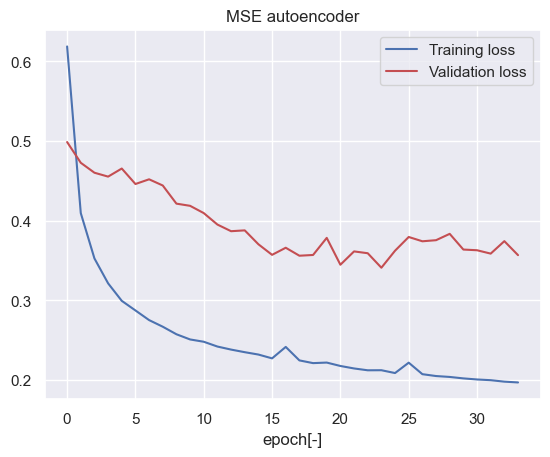

In [61]:
plot_train_history(autoenc_step_history,"MSE autoencoder")

In [62]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

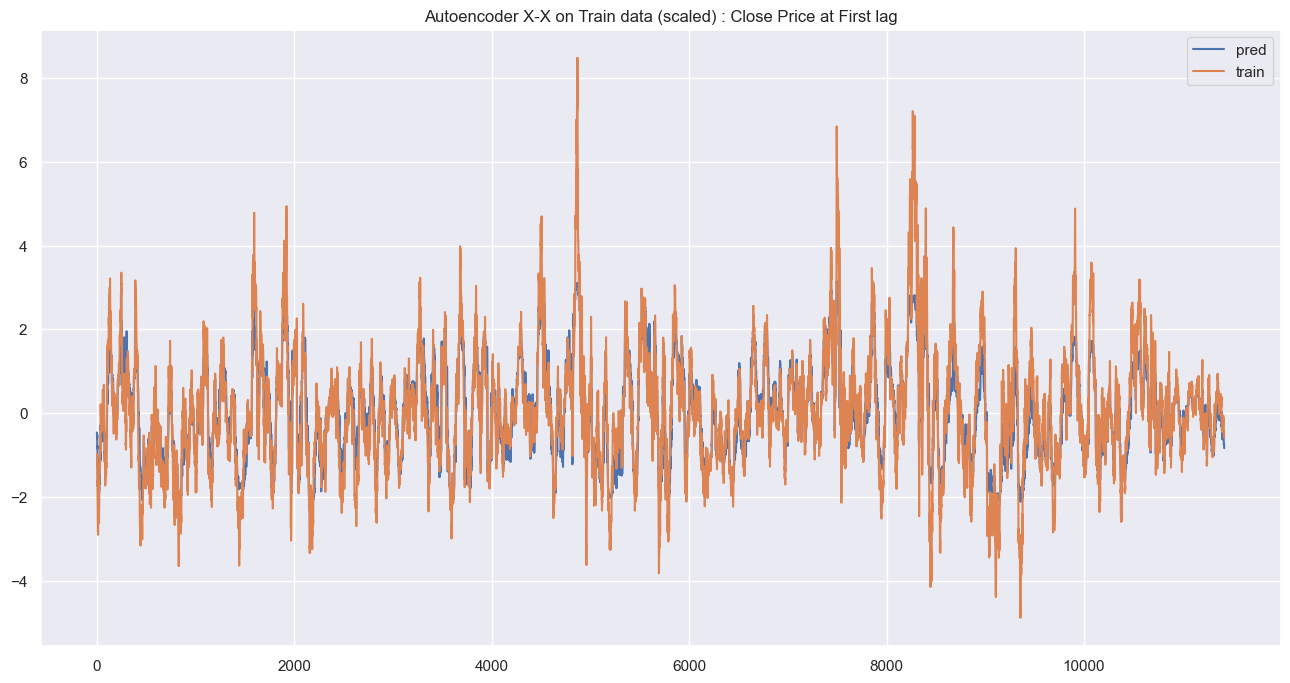

In [63]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [64]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(11422,)
(11422,)
[2106.41 2135.18 2087.34 ... 1288.9  1284.56 1282.55]
[2106.41 2135.18 2087.34]


In [65]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9882431 , 0.98136795, 0.9903947 , ..., 1.0043639 , 1.0031294 ,
       1.0022563 ], dtype=float32)

[2106.41 2135.18 2087.34 ... 1288.9  1284.56 1282.55]
[2164.72178415 2172.94825763 2151.49932522 ... 1271.14771096 1270.44392349
 1267.84043065]


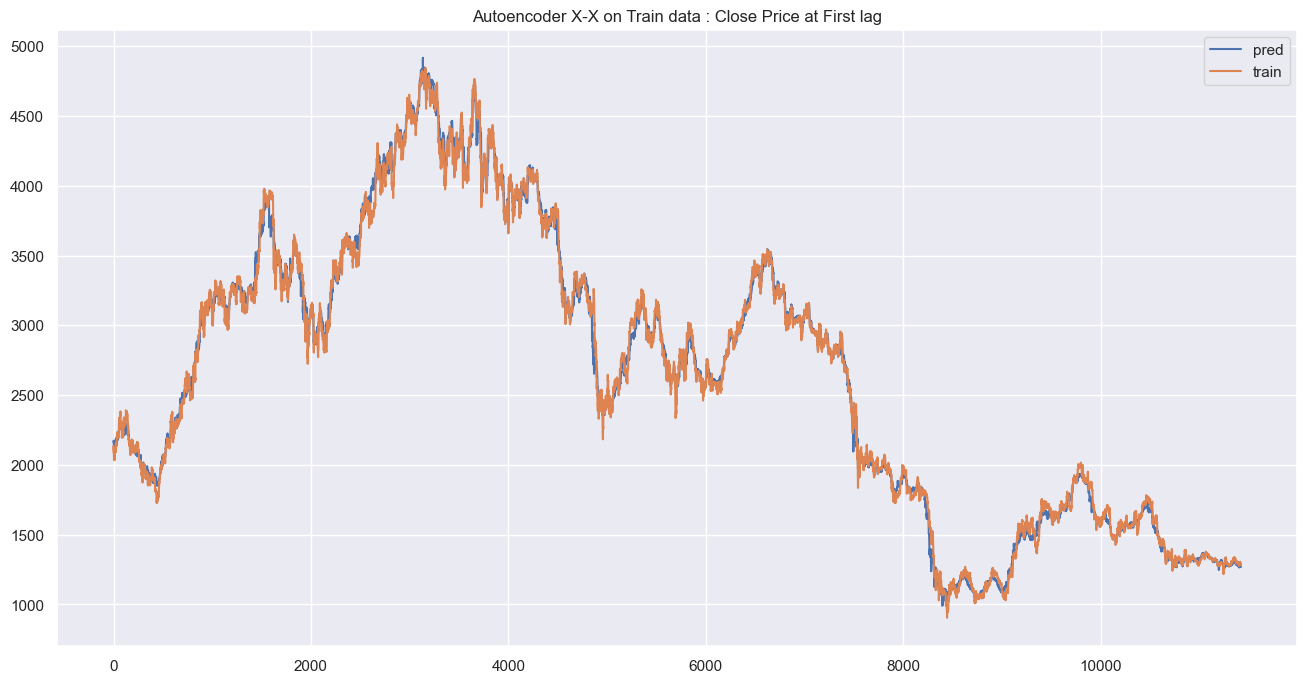

In [66]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [67]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

88/88 [==============================] - 3s 34ms/step


(2809, 48, 104)

In [68]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2022-10-23 09:00:00'

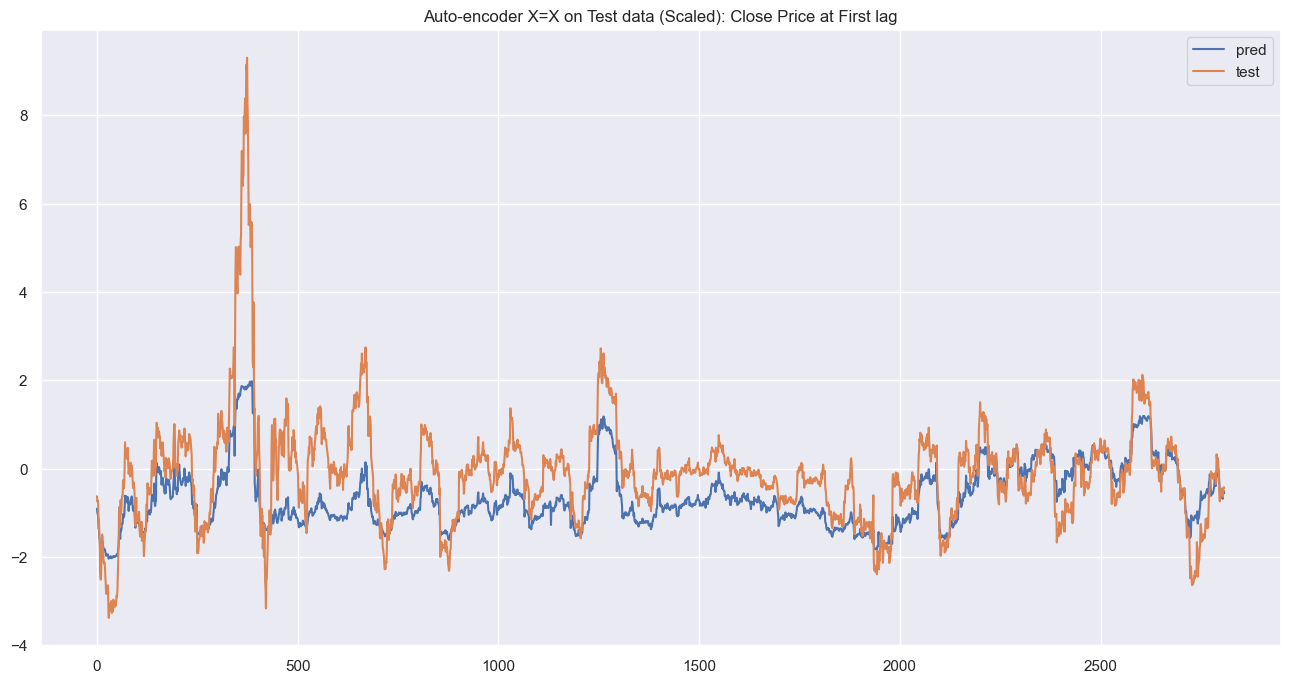

In [69]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [70]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1309.57 1304.14 1306.92 1308.27 1311.17 1313.6  1312.44 1328.69 1329.4 ]
X test pred :  [1292.57038583 1289.1327954  1288.50889179 1291.27514526 1300.9974088
 1301.72045703 1313.24538078 1329.03976474 1362.7227925 ]


[1309.57 1304.14 1306.92 ... 1664.19 1663.46 1664.61]
[1292.57038583 1289.1327954  1288.50889179 ... 1654.30624614 1658.19719638
 1655.09735492]


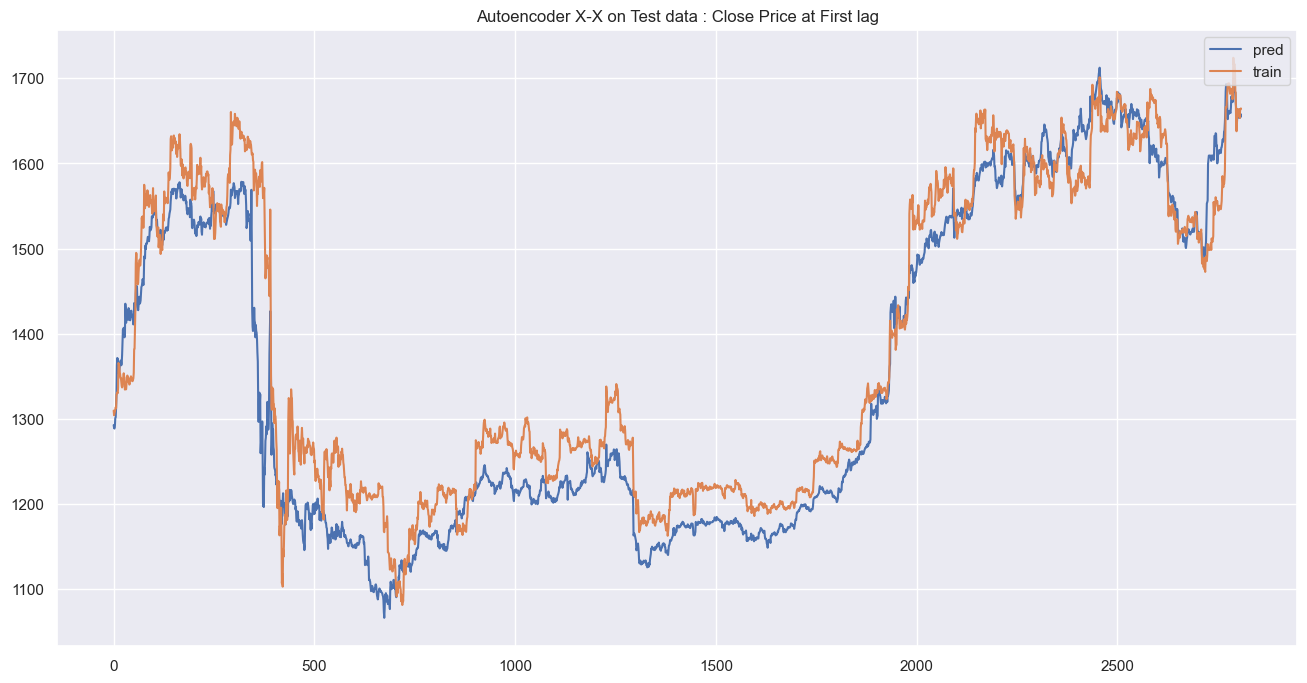

In [71]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [72]:
encoder_model.layers[3].get_weights()

[]

## Prediction Models

### LSTM all features

In [82]:
X_train_sca.shape[-1]

104

In [83]:
X_train_sca.shape[-2:]

(48, 104)

In [84]:
NB_TRY = 50
BATCH_SIZE = 32
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10 
dropout_rate = 0.4
tf.keras.backend.clear_session()
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
multi_step_model_1.add(tf.keras.layers.LSTM(64, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:]))
multi_step_model_1.add(tf.keras.layers.Dropout(0.2))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=50, 
    batch_size=32, validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Epoch 1/50


2023-02-20 00:43:32.848651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:43:33.021086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/357 [..............................] - ETA: 6:44 - loss: 1.1469

2023-02-20 00:43:33.158225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - ETA: 0s - loss: 1.0017

2023-02-20 00:43:39.774237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:43:39.835907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - 9s 21ms/step - loss: 1.0017 - val_loss: 0.6679
Epoch 2/50
357/357 [==============================] - 7s 20ms/step - loss: 0.8569 - val_loss: 0.8286
Epoch 3/50
357/357 [==============================] - 7s 20ms/step - loss: 0.7255 - val_loss: 1.0038
Epoch 4/50
357/357 [==============================] - 7s 20ms/step - loss: 0.6404 - val_loss: 1.0567
Epoch 5/50
357/357 [==============================] - 7s 20ms/step - loss: 0.5662 - val_loss: 1.0621
Epoch 6/50
357/357 [==============================] - 7s 20ms/step - loss: 0.5165 - val_loss: 1.0808
Epoch 7/50
357/357 [==============================] - 7s 20ms/step - loss: 0.4769 - val_loss: 1.3775
Epoch 8/50
357/357 [==============================] - 7s 20ms/step - loss: 0.4611 - val_loss: 1.2217
Epoch 9/50
357/357 [==============================] - 7s 20ms/step - loss: 0.4263 - val_loss: 1.3951
Epoch 10/50
357/357 [==============================] - 7s 20ms/step - loss: 0.4049 - val_loss: 1.2795


0.667859673500061

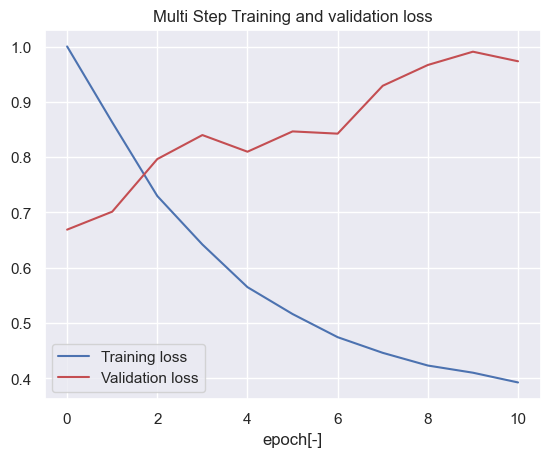

In [76]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss')

In [77]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

  7/357 [..............................] - ETA: 3s  

2023-02-20 00:20:59.003405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:20:59.061397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 9ms/step


In [78]:
y_train_pred_raw_1.shape

(11422, 13)

In [79]:
y_train_raw.shape

(11422, 13)

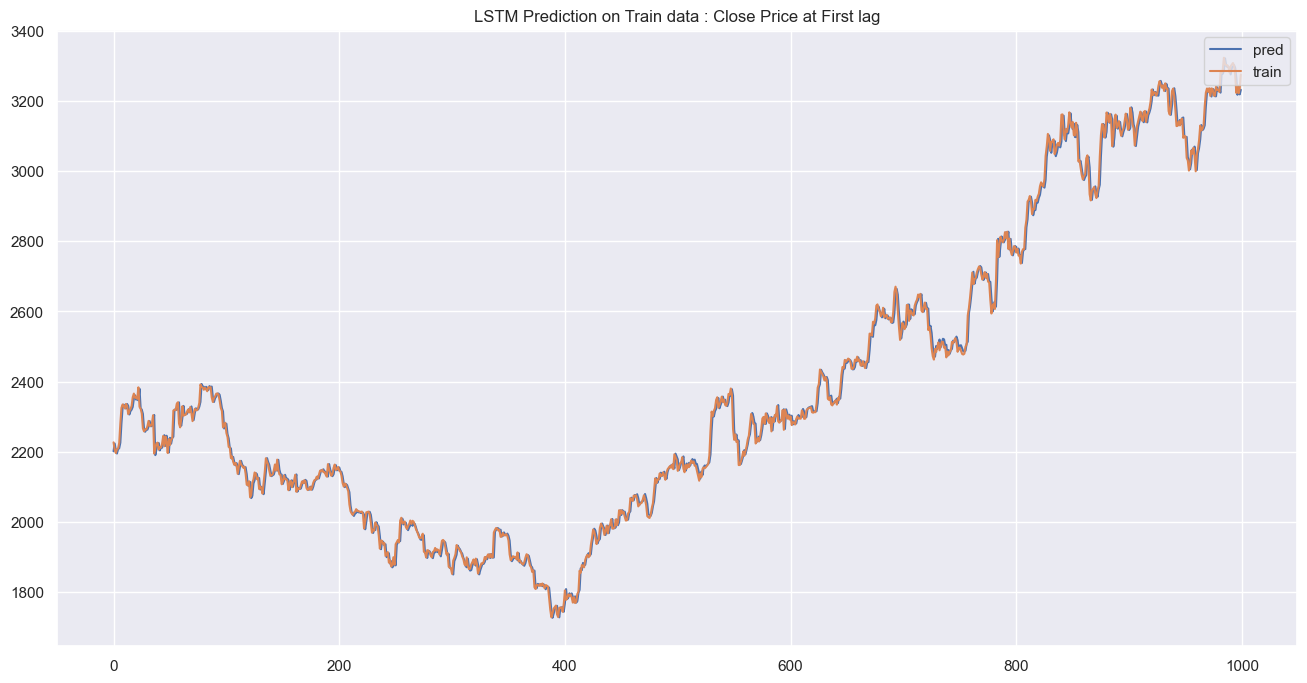

In [80]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

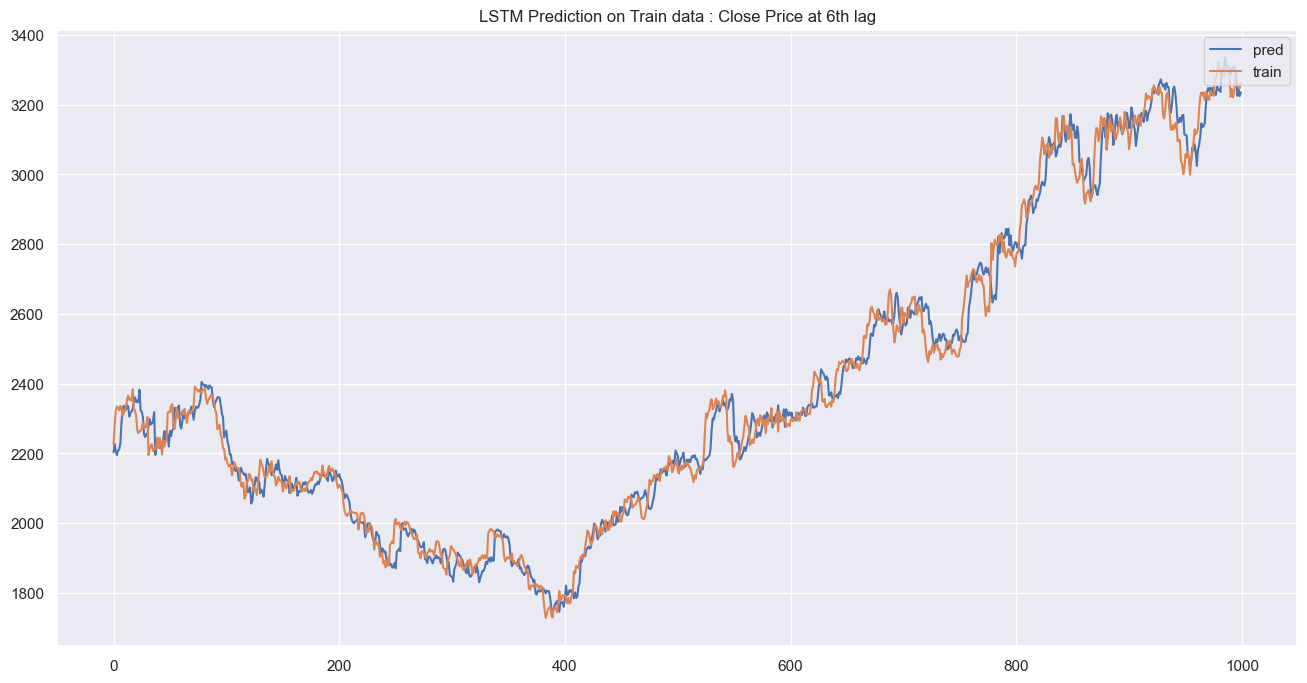

In [81]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

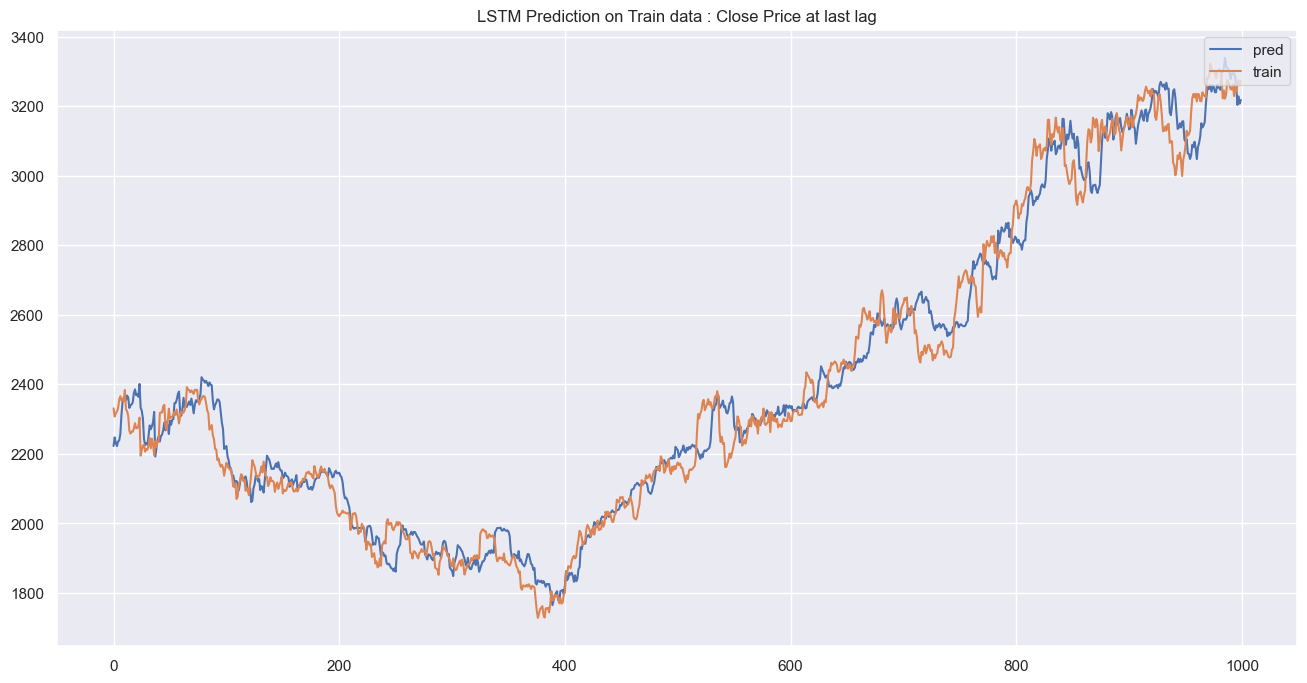

In [82]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

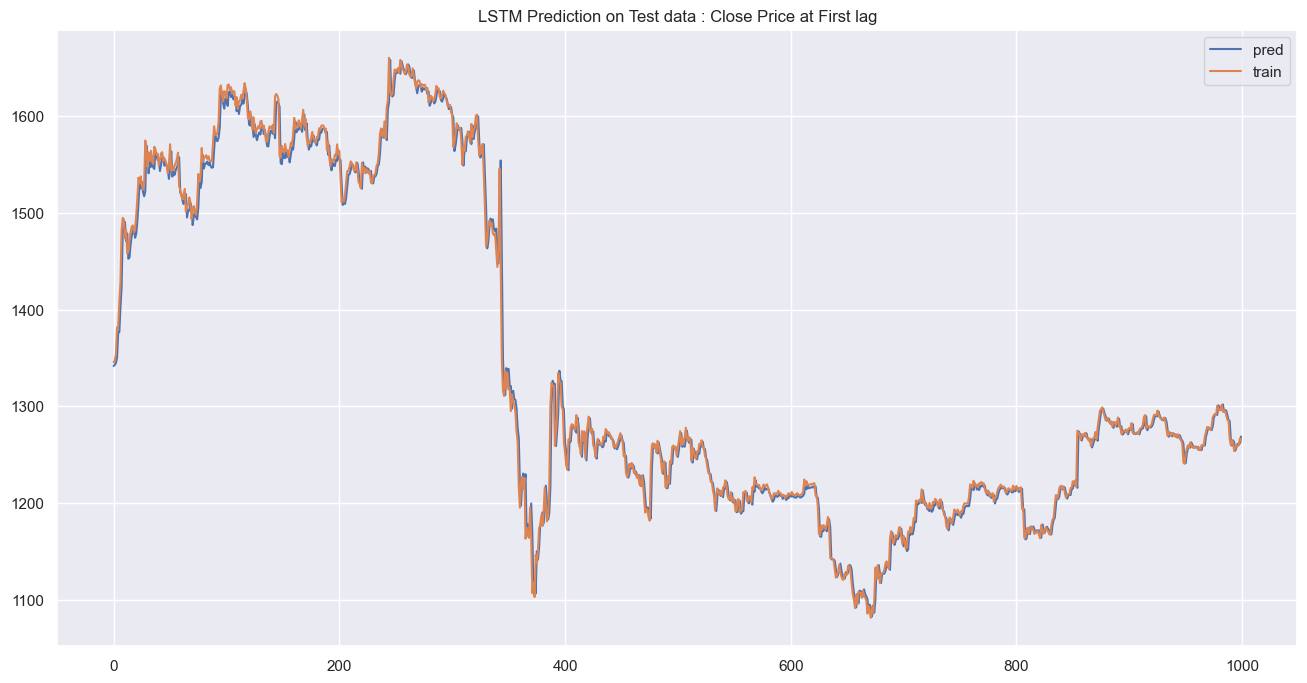

In [83]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

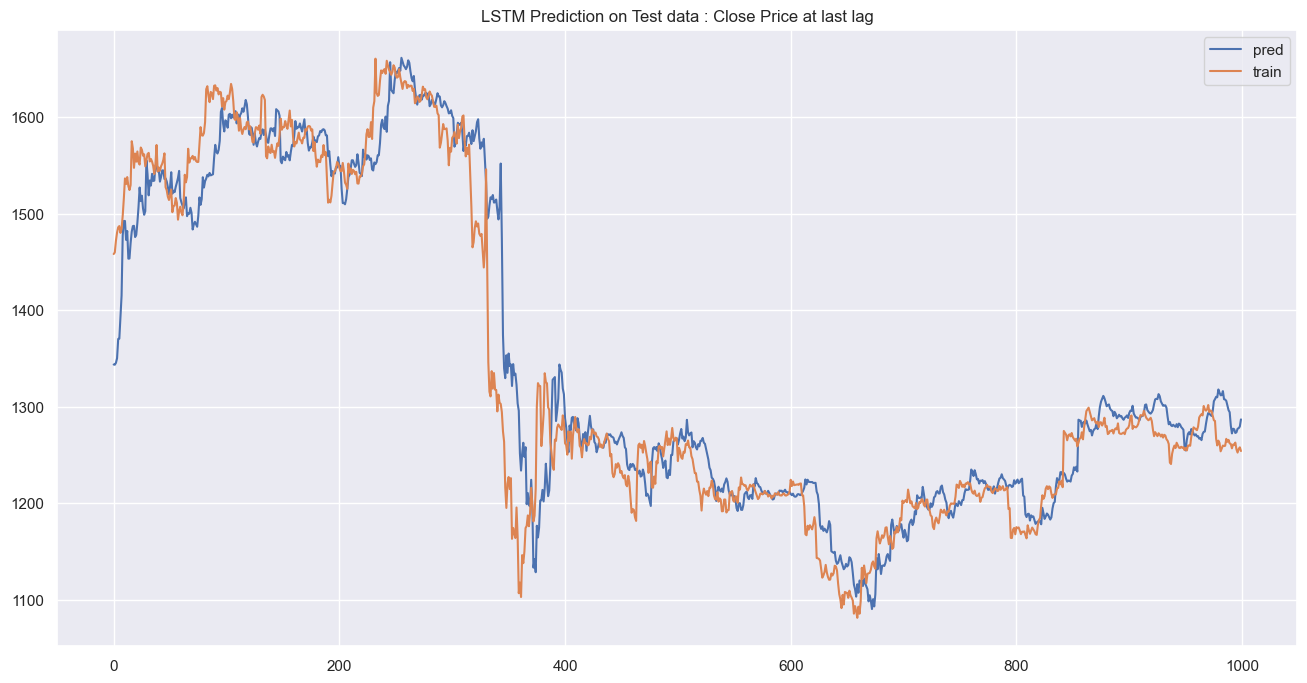

In [84]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [85]:
y_train_pred_unscaled_1[0,:]

array([0.998122  , 1.0026144 , 1.0002313 , 1.0034049 , 0.99951136,
       0.9988054 , 0.9991408 , 1.0029849 , 1.0048403 , 1.0067736 ,
       0.9954238 , 1.0059129 , 1.0076933 ], dtype=float32)

In [86]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([2201.5176, 2211.4263, 2206.17  , 2213.17  , 2204.582 , 2203.0251,
       2203.765 , 2212.2437, 2216.336 , 2220.6   , 2195.5664, 2218.7017,
       2222.6287], dtype=float32)

In [87]:
y_train_pred_raw_1[0,:]

array([2201.51771946, 2211.42643103, 2206.17009421, 2213.16995409,
       2204.58222877, 2203.02512675, 2203.76489482, 2212.24363351,
       2216.33595637, 2220.60023882, 2195.56644502, 2218.70184695,
       2222.62878359])

### Autoencoder + LSTM reduced features

In [53]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-20 00:32:07.368067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 00:32:07.368192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [88]:
X_train[:,:,0:4].shape

(11422, 48, 4)

In [89]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [59]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2023-02-20 00:34:43.005262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:34:43.114013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/357 [..............................] - ETA: 5s  

2023-02-20 00:34:43.211908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - 6s 16ms/step


(11422, 48, 12)

In [61]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

88/88 [==============================] - 2s 17ms/step


(2809, 48, 12)

In [62]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded], axis=-1)

X_train_.shape, X_test_.shape

((11422, 48, 16), (2809, 48, 16))

Train

In [57]:
NB_TRY = 50
BATCH_SIZE = 32
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10 
dropout_rate = 0.4
tf.keras.backend.clear_session()
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64, 
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=50, 
    batch_size=32, validation_data=(X_test_, y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/50


2023-02-20 00:27:42.345825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:27:42.520753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/357 [..............................] - ETA: 6:51 - loss: 1.3948

2023-02-20 00:27:42.666896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - ETA: 0s - loss: 1.0061

2023-02-20 00:27:49.364464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:27:49.427845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


357/357 [==============================] - 9s 21ms/step - loss: 1.0061 - val_loss: 0.5795
Epoch 2/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9980 - val_loss: 0.5802
Epoch 3/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9951 - val_loss: 0.5762
Epoch 4/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9929 - val_loss: 0.5779
Epoch 5/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9898 - val_loss: 0.5760
Epoch 6/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9828 - val_loss: 0.5740
Epoch 7/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9738 - val_loss: 0.5896
Epoch 8/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9690 - val_loss: 0.5827
Epoch 9/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9565 - val_loss: 0.5798
Epoch 10/50
357/357 [==============================] - 7s 20ms/step - loss: 0.9457 - val_loss: 0.5996


0.5739878416061401

### Results

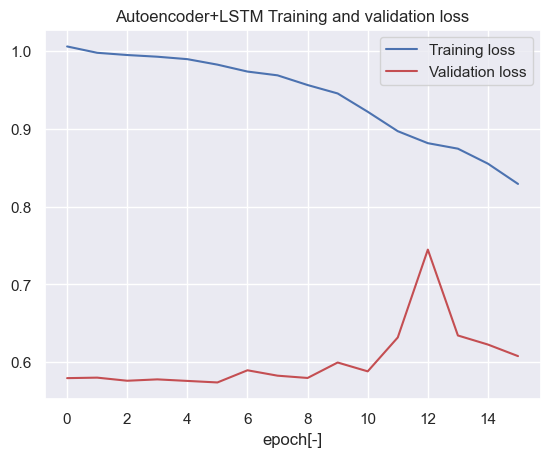

In [60]:
plot_train_history(multi_step_history,
                       'Autoencoder+LSTM Training and validation loss')

In [61]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


In [62]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred = multi_step_model.predict(X_train_)
y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred = multi_step_model.predict(X_test_)
y_test_pred_unscaled = scaler_y.inverse_transform(y_test_pred.reshape(-1,y_test_pred.shape[-1])).reshape(y_test_pred.shape)
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

  7/357 [..............................] - ETA: 3s  

2023-02-20 00:30:27.428378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:30:27.484103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 9ms/step


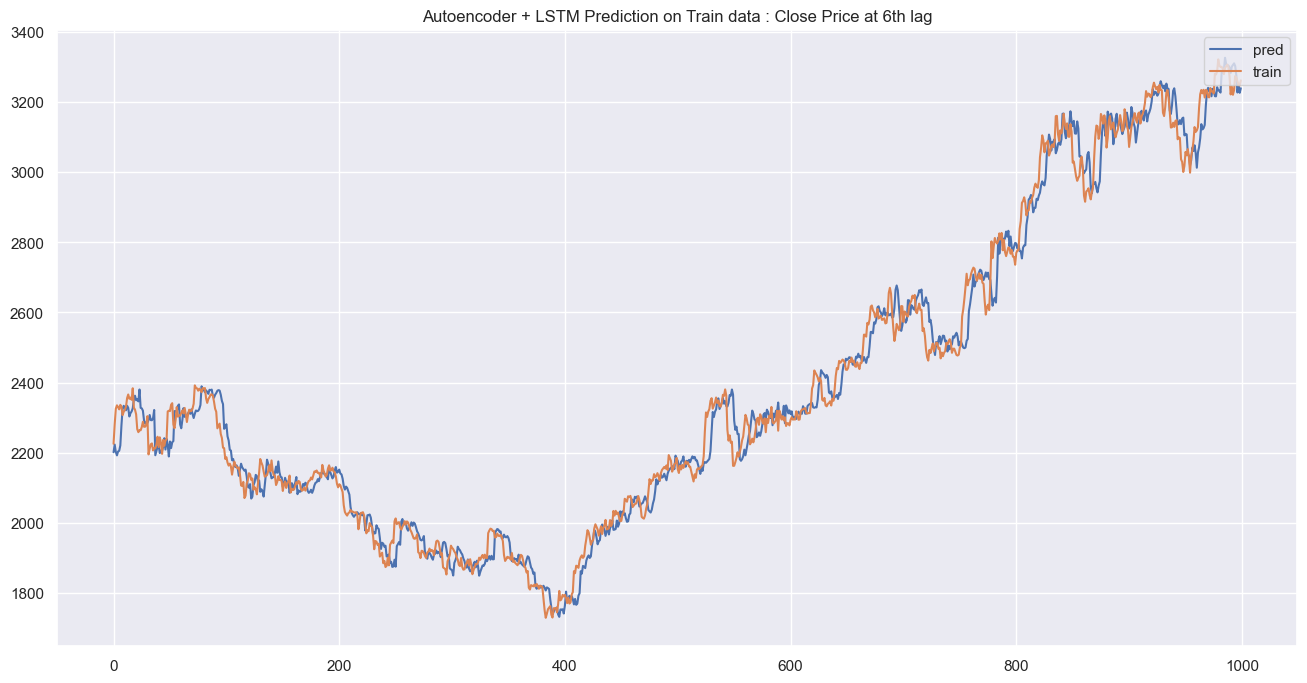

In [63]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

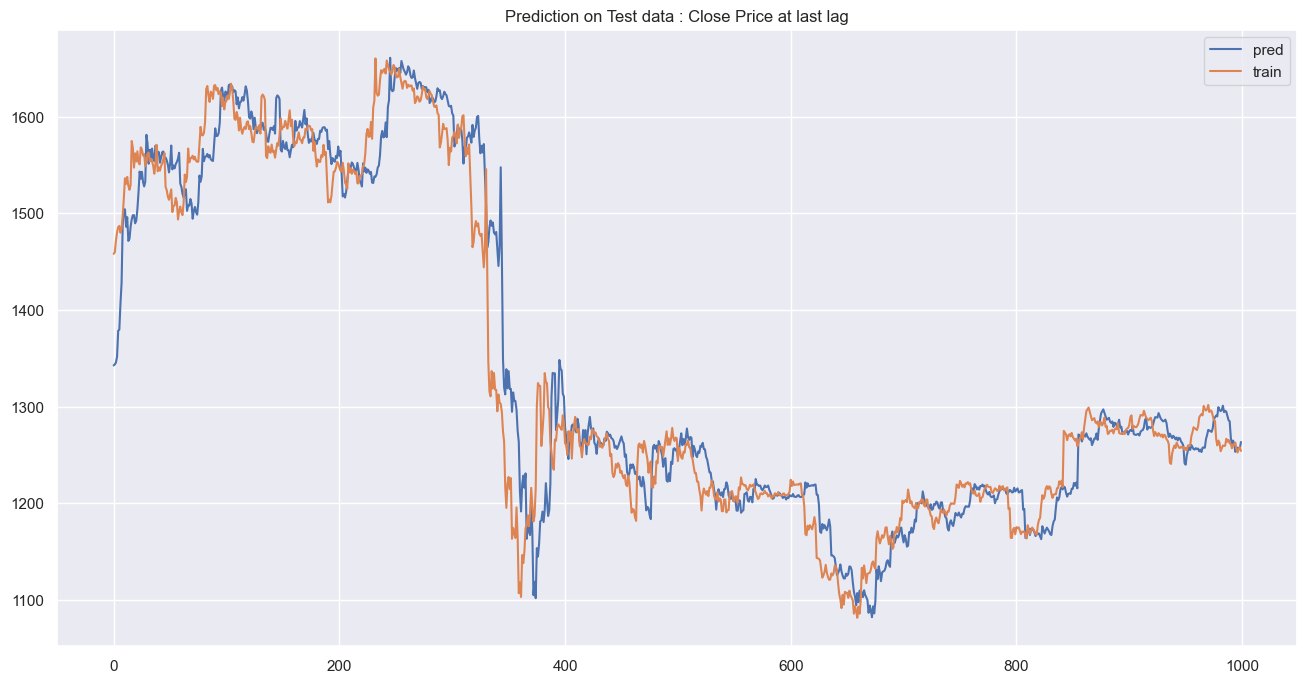

In [64]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

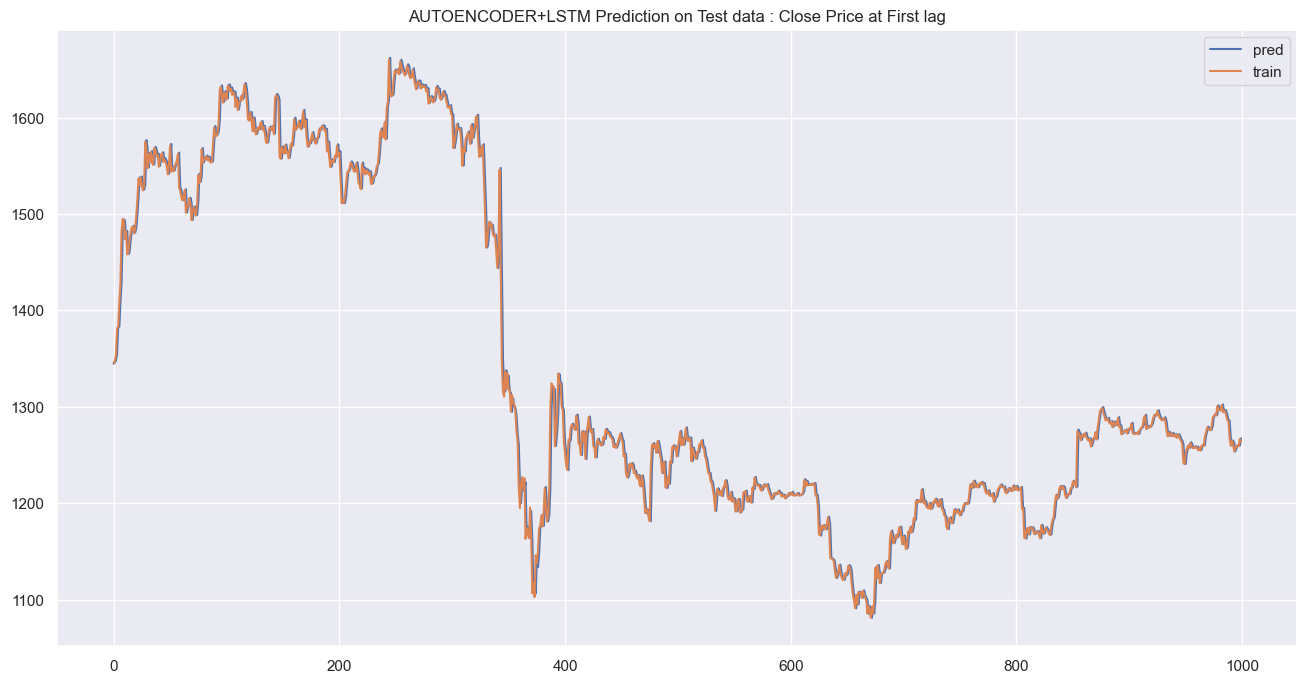

In [98]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

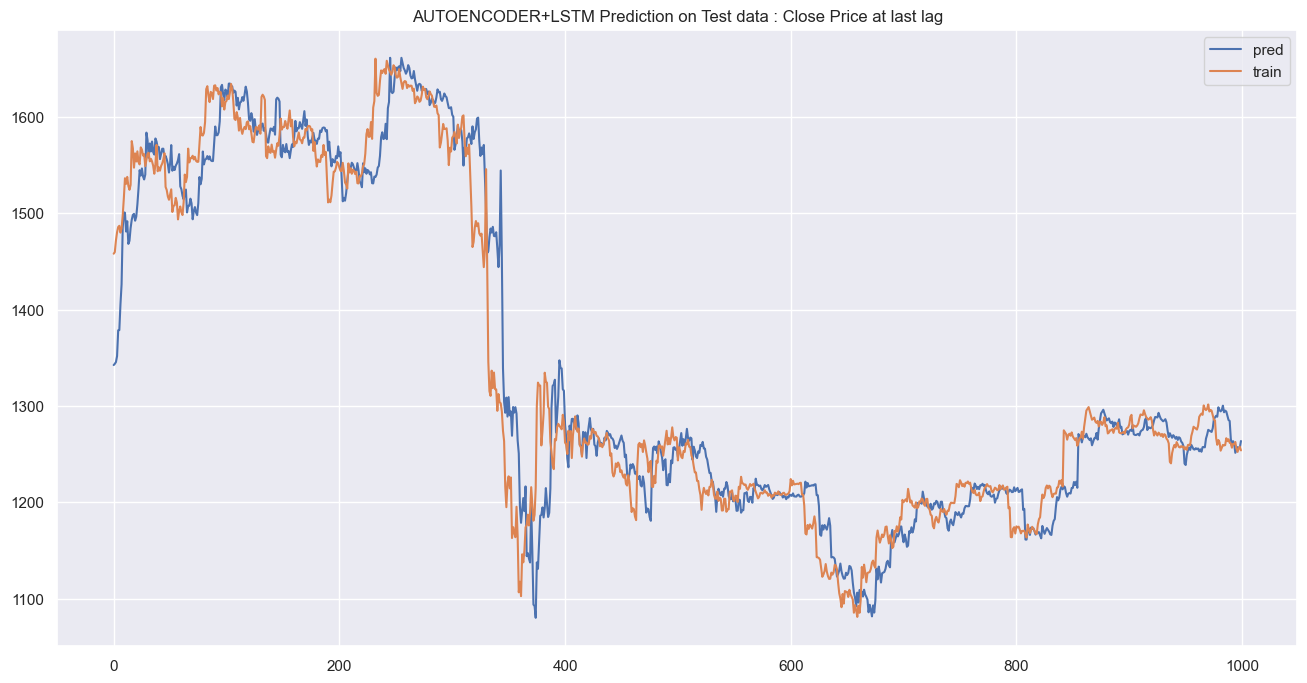

In [99]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [100]:
str(time.time())

'1676849007.044627'

## Save best prediction

In [101]:
X_test_sca.shape

(2809, 48, 104)

In [ ]:
df_feat["Close_ETH"].iloc[-1]

In [68]:
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)

In [77]:
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]

In [78]:
X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]

In [79]:
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)

In [81]:
X_last_sca.shape

(1, 48, 104)

In [80]:
X_last_sca = X_last_sca[:,:,:4]

(1, 48, 104)

In [72]:
y_last_pred = multi_step_model.predict(X_last_sca)

ValueError: in user code:

    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/gregory/miniforge3/envs/ocean_tf/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 48, 16), found shape=(None, 48, 104)


In [85]:
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
# divided price
X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
# scaler
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
y_last_pred = multi_step_model_1.predict(X_last_sca)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
y_last_pred_raw

1/1 [==============================] - 0s 297ms/step


2023-02-20 00:45:44.962785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 00:45:45.025678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[1676.4545, 1672.0531, 1680.8876, 1667.468 , 1670.1584, 1678.7974,
        1662.3367, 1662.5453, 1684.7573, 1659.3712, 1654.6205, 1691.6415,
        1637.5485]], dtype=float32)

In [86]:
#file_name = "/tmp/pred_vals.csv"
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
save_list(list_pred, path_save_pred_vals)